# $N$-way registration

In order to do registration over multiple images, I did a literature review and found a couple papers.

* [Practical Guide to Multi-Image Alignment](https://arxiv.org/pdf/1802.03280.pdf)
* [Highly Accurate Inverse Consistent Registration: A Robust Approach](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2946852/)
* [Within-subject template estimation for unbiased longitudinal image analysis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3389460/)

The first paper discusses techniques of estimation by MLE and MAP. The second and third discuss more basic techniques. Specifically, in the second paper for robust registration, Reuter discusses using the median to reduce the effects of outliers. In the third paper, "an unbiased, within-subject template is generated by iteratively aligning all input images to a median image using a symmetric robust registration method".
    
    
In particular, template estimation of $N$ images $I_i$ is finding a $\hat{I}$ that minimizes an objective function of similarity, or closeness, of the template $\hat{I}$ to all the images $I_i$. Specifically, 
$$\left\{\hat{I}, \hat{\varphi}_i\right\} = \arg\min\limits_{I, \phi_i}\sum_{i=1}^N E(I_i \circ \varphi_i, I) + D(\varphi_i)^2,$$

where $\varphi_i$ is a rotation in 3-space, $E$ is an image dissimilarity metric and $D$ is a distance function (all specified in the paper).

Reuter lists the following method for registering $N$ images.
    
1. Compute the median of the $N$ input images $\hat{I}$.
2. Register and resample each input image to $\hat{I}$.
3. Continue with step 1 until the obtained transforms $\varphi_i$ converge.

This notebook will be an implementation of the above registration algorithm.

## Setting up imports, functions, and reading in data

In [38]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import ndreg
from ndreg import preprocessor, registerer, util
import SimpleITK as sitk
import numpy as np
import imageio

In [3]:
import warnings
warnings.simplefilter("ignore")

In [4]:
def normalize(img, percentile=0.99):
    #Accept ndarray images or sitk images
    if type(img) is np.ndarray:
        sitk_img = sitk.GetImageFromArray(img)
    else:
        sitk_img = img
    max_val = ndreg.imgPercentile(sitk_img, percentile)
    return sitk.Clamp(sitk_img, upperBound=max_val) / max_val

In [5]:
def process(im, vmin=0, vmax=65535):
    """
    Input: SITK Image
    Output: Clipped and normalized SITK Image
    """
    temp = np.clip(sitk.GetArrayFromImage(im), vmin, vmax)
    return normalize(temp)

In [6]:
def calculate_error(im1, im2, verbose=False):
    depth = min(im1.GetDepth(), im2.GetDepth())
    errors = []
    for i in range(depth):
        error = registerer.imgMSE(normalize(im1[:,:,i]), normalize(im2[:,:,i]))
        errors.append(error)
        if verbose:
            print("Slice {}: Registration error is: {} voxels^2".format(i, error))
    
    return errors

In [7]:
def plot_error(errors, title="", xlabel="Log Square Voxel Error", ylabel="Slice", save=None):
    plt.figure()
    plt.title(title)
    ax = plt.axes()
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().invert_yaxis()
    plt.plot(np.log10(errors), range(len(errors)))

    if save is not None:
        plt.savefig(save)

    plt.show()
    plt.close()

In [8]:
def generate_overlay(im1, im2, title="", save=None):
    depth = max(im1.GetDepth(), im2.GetDepth())
    
    for i in range(depth):
        fig = plt.figure(figsize=(5, 6))
        plt.imshow(sitk.GetArrayViewFromImage(im1[:,:,i]), cmap='Purples', alpha=0.5)
        plt.imshow(sitk.GetArrayViewFromImage(im2[:,:,i]), cmap='Greens', alpha=0.5)
        plt.axis('off')
        plt.title('{}\nSlice {}'.format(title, i))
        if save is not None:
            plt.savefig("{}_slice{:02d}".format(save, i))

#         plt.show()
        plt.close()    

In [9]:
tp1 = util.imgRead('./data/R04_tp1.tif')
tp2 = util.imgRead('./data/R04_tp2.tif')
tp3 = util.imgRead('./data/R04_tp3.tif')
tp4 = util.imgRead('./data/R04_tp4.tif')

## Computing median of images

After taking the median we process the images by clipping and normalizing. Reasons and a demonstration of the effectiveness of this processing can be found [here](https://github.com/NeuroDataDesign/LIDS/blob/master/registration/image_processing_demo.ipynb).

In [10]:
%%time 

depth = min(tp1.GetDepth(), tp2.GetDepth(), tp3.GetDepth(), tp4.GetDepth())

tp1_processed = process(tp1[:,:,:depth], vmin=-5000, vmax=10000)
tp2_processed = process(tp2[:,:,:depth], vmin=-5000, vmax=10000)
tp3_processed = process(tp3[:,:,:depth], vmin=-5000, vmax=10000)
tp4_processed = process(tp4[:,:,:depth], vmin=-5000, vmax=10000)

CPU times: user 6.66 s, sys: 1.37 s, total: 8.03 s
Wall time: 4.78 s


In the interest of time, we'll be using only an octant of the entire stack of each image.

In [11]:
width = min(tp1.GetWidth(), tp2.GetWidth(), tp3.GetWidth(), tp4.GetWidth())
height = min(tp1.GetHeight(), tp2.GetHeight(), tp3.GetHeight(), tp4.GetHeight())

width = width/2
height= height/2
depth = depth/2

tp1_processed = tp1_processed[:width, :height, :depth]
tp2_processed = tp2_processed[:width, :height, :depth]
tp3_processed = tp3_processed[:width, :height, :depth]
tp4_processed = tp4_processed[:width, :height, :depth]

In [12]:
imageio.mimwrite('gifs/tp1_processed.gif', [sitk.GetArrayFromImage(tp1_processed[:,:,i]) for i in range(depth)], 
                  format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('gifs/tp2_processed.gif', [sitk.GetArrayFromImage(tp2_processed[:,:,i]) for i in range(depth)], 
                  format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('gifs/tp3_processed.gif', [sitk.GetArrayFromImage(tp3_processed[:,:,i]) for i in range(depth)], 
                  format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('gifs/tp4_processed.gif', [sitk.GetArrayFromImage(tp4_processed[:,:,i]) for i in range(depth)], 
                  format='gif', duration = 2 * 50/(24. * 60))

| Timepoint 1                                      |               Timepoint 2                          |
|--------------------------------------------------|----------------------------------------------------|
|<img src="gifs/tp1_processed.gif" style="width: 300px">| <img src="gifs/tp2_processed.gif" style="width: 300px"> |

| Timepoint 3                                      |               Timepoint 4                          |
|--------------------------------------------------|----------------------------------------------------|
|<img src="gifs/tp3_processed.gif" style="width: 300px">| <img src="gifs/tp4_processed.gif" style="width: 300px"> |


In [13]:
stack = np.array([sitk.GetArrayFromImage(tp1_processed), sitk.GetArrayFromImage(tp2_processed), 
                  sitk.GetArrayFromImage(tp3_processed), sitk.GetArrayFromImage(tp4_processed)])
median = np.median(stack, axis=0)

In [14]:
imageio.mimwrite('gifs/median.gif', [median[i] for i in range(depth)], 
                  format='gif', duration = 2 * 50/(24. * 60))

<img src='gifs/median.gif' style='width:300px'>

## Registering Images $I_i$ to Median 

Use ndreg.register_rigid to do a rigid registration to the mean

In [15]:
input_images = [tp1_processed, tp2_processed, tp3_processed, tp4_processed]
atlas = sitk.GetImageFromArray(median)

In [16]:
%%time

corrected_imgs = []
for i in range(len(input_images)):
    img = input_images[i]
    print("Registering timepoint {} to median".format(i+1))
    final_transform = registerer.register_rigid(atlas, img, learning_rate=1e-1, iters=5)
    print("Resampling Image")
    corrected_img = registerer.resample(atlas, final_transform, img)
    corrected_imgs.append(corrected_img)

Registering timepoint 1 to median
Resampling Image
Registering timepoint 2 to median
Resampling Image
Registering timepoint 3 to median
Resampling Image
Registering timepoint 4 to median
Resampling Image
CPU times: user 5min 16s, sys: 220 ms, total: 5min 16s
Wall time: 49.8 s


In [17]:
im1, im2, im3, im4 = corrected_imgs

In [18]:
resampled_images = np.array([sitk.GetArrayFromImage(corrected_imgs[i]) for i in range(len(corrected_imgs))])

In [19]:
resample1, resample2, resample3, resample4 = resampled_images

In [20]:
# write to gif
imageio.mimwrite('resample_tp1.gif', [resample1[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('resample_tp2.gif', [resample2[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('resample_tp3.gif', [resample3[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('resample_tp4.gif', [resample4[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))

In [21]:
new_median = np.median(resampled_images, axis=0)

In [40]:
errors = calculate_error(sitk.GetImageFromArray(median), sitk.GetImageFromArray(new_median))

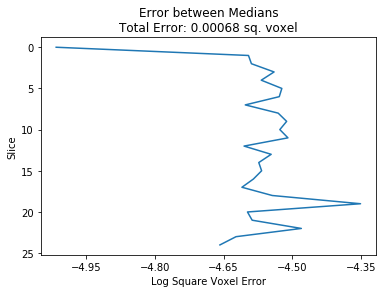

In [41]:
plot_error(errors, title='Error between Medians\nTotal Error: {:.5f} sq. voxel'.format(np.sum(errors)))

# Turn everything above into a function

In [24]:
def register_rigid_n_way(image_list, 
                             epsilon = 1e-2,
                             medians = 10,
                             learning_rate=1e-2, 
                             iters=200, 
                             min_step=1e-10, 
                             shrink_factors=[1], 
                             sigmas=[.150], 
                             use_mi=False, 
                             grad_tol=1e-6, 
                             verbose=False):
    
    """
    Register N 3-D images with rigid transformation.
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3389460/
    
    1. Compute median of input images
    2. Register and resample images with median as atlas
    3. Repeat until transforms converge    
    

    Parameters:
        n-way:
            image_list,    - input images (array of SimpleITK.SimpleITK.Image s)
            epsilon = 1e-2 - convergence threshold: MSE between consecutive median atlases
            medians = 10,  - maximum number of medians to calculate (upper limit for running time)
    
        register_rigid:
            learning_rate=1e-2, 
            iters=200, 
            min_step=1e-10, 
            shrink_factors=[1], 
            sigmas=[.150], 
            use_mi=False, 
            grad_tol=1e-6, 
            verbose=False

    """
    
    depth = min([img.GetDepth() for img in image_list])
    source_images = [img[:,:,:depth] for img in image_list]
    
    atlas = sitk.GetImageFromArray(np.median([sitk.GetArrayFromImage(img) for img in image_list], axis=0))
    
    errors = []
    #init tranforms to identity and compose new transforms on top of it
    final_transforms = [sitk.Transform(sitk.TranslationTransform(3, (0,0,0))) for i in range(len(images))]
    
    #repeat until convergence
    for _ in range(medians):
        new_images = []
        for i in range(len(source_images)):
            print("Image {} of {}".format(i+1, len(source_images)))
            img = source_images[i]
            transform = registerer.register_rigid(atlas, img, 
                                                        learning_rate=learning_rate, 
                                                        iters=iters, 
                                                        min_step=min_step, 
                                                        shrink_factors=shrink_factors, 
                                                        sigmas=sigmas, 
                                                        use_mi=use_mi, 
                                                        grad_tol=grad_tol, 
                                                        verbose=verbose)
            new_images.append(registerer.resample(atlas, transform, img))
            final_transforms[i].AddTransform(transform)
    
        #images for next pass or output
        source_images = new_images
        new_atlas = sitk.GetImageFromArray(np.median(np.array(
            [sitk.GetArrayFromImage(img) for img in source_images]), axis=0))

        total_error = np.sum(calculate_error(atlas, new_atlas))
        errors.append(total_error)
       
        #Convergence check (early stopping)
        if total_error < epsilon:
            break
    return final_transforms, errors

In [25]:
images = [tp1_processed, tp2_processed, tp3_processed, tp4_processed]

In [26]:
%%time

transforms, errors = register_rigid_n_way(images, epsilon = 1e-2, learning_rate=1e-2, iters=1)

Image 1 of 4
Image 2 of 4
Image 3 of 4
Image 4 of 4
CPU times: user 1min 38s, sys: 744 ms, total: 1min 39s
Wall time: 21 s


In [27]:
atlas = sitk.GetImageFromArray(np.median([sitk.GetArrayFromImage(img) for img in images], axis=0))
corrected_images = [registerer.resample(atlas, transforms[i], images[i]) for i in range(len(images))]

In [28]:
resampled_images = np.array([sitk.GetArrayFromImage(image) for image in corrected_images])

In [29]:
final_median = sitk.GetImageFromArray(np.median(resampled_images, axis=0))

In [30]:
resample1, resample2, resample3, resample4 = resampled_images
# write to gif
imageio.mimwrite('gifs/register_median_tp1.gif', [resample1[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('gifs/register_median_tp2.gif', [resample2[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('gifs/register_median_tp3.gif', [resample3[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('gifs/register_median_tp4.gif', [resample4[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))

| Timepoint 1                                      |               Timepoint 2                          |
------------------------------------------------|----------------------------------------------------|
|<img src="gifs/register_median_tp1.gif" style="width: 300px">| <img src="gifs/register_median_tp2.gif" style="width: 300px"> |

| Timepoint 3                                      |               Timepoint 4                          |
|--------------------------------------------------|----------------------------------------------------|
|<img src="gifs/register_median_tp3.gif" style="width: 300px">| <img src="gifs/register_median_tp4.gif" style="width: 300px"> |


In [31]:
imageio.mimwrite('gifs/final_median.gif', [sitk.GetArrayFromImage(final_median)[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))

In [42]:
tp1_err = calculate_error(sitk.GetImageFromArray(resample1), final_median)
tp2_err = calculate_error(sitk.GetImageFromArray(resample2), final_median)
tp3_err = calculate_error(sitk.GetImageFromArray(resample3), final_median)
tp4_err = calculate_error(sitk.GetImageFromArray(resample4), final_median)

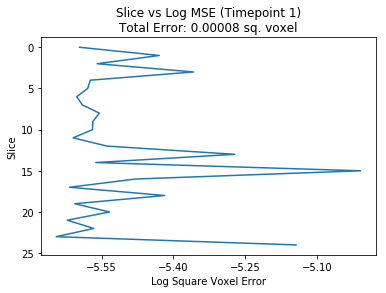

In [43]:
plot_error(tp1_err, title='Slice vs Log MSE (Timepoint 1)\nTotal Error: {:.5f} sq. voxel'.format(np.sum(tp1_err)))

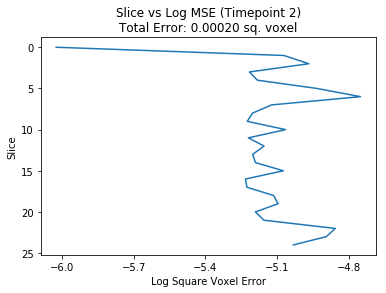

In [44]:
plot_error(tp2_err, title='Slice vs Log MSE (Timepoint 2)\nTotal Error: {:.5f} sq. voxel'.format(np.sum(tp2_err)))

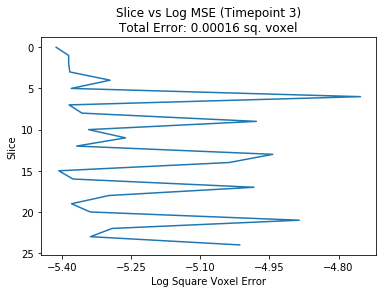

In [45]:
plot_error(tp3_err, title='Slice vs Log MSE (Timepoint 3)\nTotal Error: {:.5f} sq. voxel'.format(np.sum(tp3_err)))

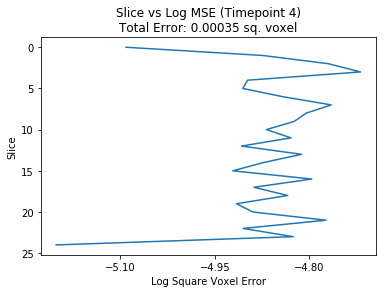

In [46]:
plot_error(tp4_err, title='Slice vs Log MSE (Timepoint 4)\nTotal Error: {:.5f} sq. voxel'.format(np.sum(tp4_err)))

In [47]:
generate_overlay(corrected_images[0], final_median, title='Timepoint 1 and Final Median Overlay', save='output/n-way/tp1/tp1_median_overlay');

generate_overlay(corrected_images[1], final_median, title='Timepoint 2 and Final Median Overlay', save='output/n-way/tp2/tp2_median_overlay');

generate_overlay(corrected_images[2], final_median, title='Timepoint 3 and Final Median Overlay', save='output/n-way/tp3/tp3_median_overlay');

generate_overlay(corrected_images[3], final_median, title='Timepoint 3 and Final Median Overlay', save='output/n-way/tp4/tp4_median_overlay');

In [48]:
import os

tp1_overlay = []
tp2_overlay = []
tp3_overlay = []
tp4_overlay = []

for subdir, dirs, files in os.walk('output/n-way/tp1'):
    for file in sorted(files):
        file_path = os.path.join(subdir, file)
        if file_path.endswith(".png"):
            tp1_overlay.append(plt.imread(file_path))
            
for subdir, dirs, files in os.walk('output/n-way/tp2'):
    for file in sorted(files):
        file_path = os.path.join(subdir, file)
        if file_path.endswith(".png"):
            tp2_overlay.append(plt.imread(file_path))      
            
for subdir, dirs, files in os.walk('output/n-way/tp3'):
    for file in sorted(files):
        file_path = os.path.join(subdir, file)
        if file_path.endswith(".png"):
            tp3_overlay.append(plt.imread(file_path))
            
for subdir, dirs, files in os.walk('output/n-way/tp4'):
    for file in sorted(files):
        file_path = os.path.join(subdir, file)
        if file_path.endswith(".png"):
            tp4_overlay.append(plt.imread(file_path))                  

In [49]:
imageio.mimwrite('gifs/tp1_median_overlay.gif', [tp1_overlay[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('gifs/tp2_median_overlay.gif', [tp2_overlay[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('gifs/tp3_median_overlay.gif', [tp3_overlay[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))
imageio.mimwrite('gifs/tp4_median_overlay.gif', [tp4_overlay[i] for i in range(depth)], 
                 format='gif', duration = 2 * 50/(24. * 60))

| Timepoint 1                                      |               Timepoint 2                          |
------------------------------------------------|----------------------------------------------------|
|<img src="gifs/tp1_median_overlay.gif" style="width: 400px">| <img src="gifs/tp2_median_overlay.gif" style="width: 400px"> |

| Timepoint 3                                      |               Timepoint 4                          |
|--------------------------------------------------|----------------------------------------------------|
|<img src="gifs/tp3_median_overlay.gif" style="width: 400px">| <img src="gifs/tp4_median_overlay.gif" style="width: 400px"> |
